In [9]:
!git clone https://github.com/superring/topic_model.git

fatal: destination path 'topic_model' already exists and is not an empty directory.


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
!pip install -r ./topic_model/requirements.txt

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached https://files.pythonhosted.org/packages/c1/72/20f8f60b858556fdff6c0376b480c230e594621fff8be780603ac9c47f6a/mecab_python3-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/51/48f3fc47c4e2144da2806dfb6629c4dd1fa3d5a143f9652b141e979a8ca9/pandas-1.2.4-cp37-cp37m-manylinux1_x86_64.whl
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.23.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement notebook~=5.3.0; python_version >= "3.0", but you'll have notebook 6.4.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1

In [1]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already instal

In [13]:
import glob
import urllib
import MeCab
import subprocess
import gensim
import math
import matplotlib
import matplotlib.pylab as plt
import pandas as pd
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
FONT = "./topic_model/ArialUnicodeMS.ttf"

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# ニュースのテキストファイルのパス
text_paths = glob.glob('./topic_model/text/**/*.txt')

# 形態素解析用のストップワードの定義
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# 形態素解析用の関数定義。固有名詞、名詞、動詞、形容詞を中心に
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):
    node = mecab.parseToNode(text)
    words = []
    while node:
        features = node.feature.split(',')
        surface = features[6]
        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue
        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')
        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)
        node = node.next
    return words


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# LDAのための辞書とコーパス作成
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
mecab = MeCab.Tagger("-d {0}".format(path))

titles = []
texts = []
docs = []
titles = []
for text_path in text_paths:

    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
    texts.append(words)
    docs.append(text)
    titles.append(title)
    
dictionary = gensim.corpora.Dictionary(texts)
# 出現回数3未満、出現割合50%以上の単語を削除
dictionary.filter_extremes(no_below=3, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in texts]

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


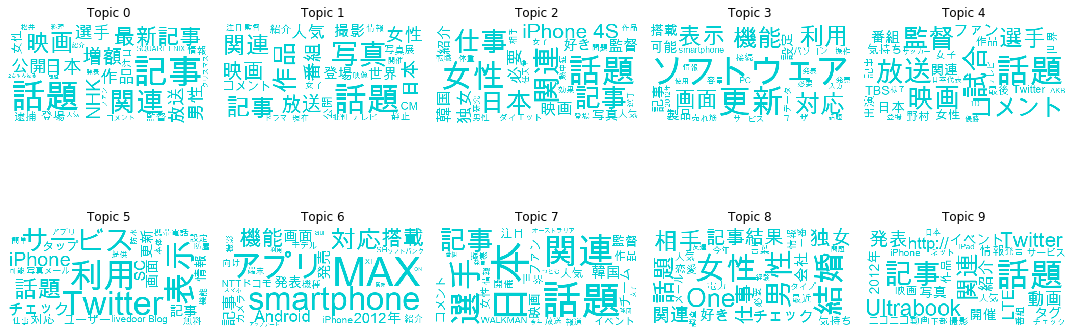

In [6]:
# LDAモデリングの実行
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)
# 可視化
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(font_path=FONT, background_color='white', color_func=color_func, random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i))

plt.tight_layout()
plt.savefig("./visualize.png")

In [7]:
# pyLDAvisによる可視化
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, './pyldavis_output.html')

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# 各記事の主要トピックを表示
# 関数定義
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# 10個の記事の主要トピックを表示
df_topic_docs_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=titles)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.5239,"結婚, 女性, 男性, One, 相手, 話題, 独女, 仕事, 記事, 結果",大人女子が指名買いする「Lavshuca」の新作アイテムが登場
1,1,5.0,0.4198,"利用, Twitter, 表示, サービス, 話題, iPhone, チェック, SC, 画...",私が楽しむバレンタイン “スイーツマルシェ 〜お菓子市場〜”
2,2,6.0,0.7562,"MAX, smartphone, アプリ, 対応, 機能, 搭載, Android, 記事,...",タイプ別で選ぶ「ガール」のためのオススメアプリ／スマホ女子特集（前編）
3,3,2.0,0.7147,"話題, 女性, 関連, 仕事, 日本, 記事, iPhone 4S, 必要, 独女, 韓国",インタビュー：エッセイスト・上原愛加さん「甘い物と幸せがなくては、生きて行けません（笑）」
4,4,1.0,0.5552,"話題, 写真, 作品, 記事, 関連, 映画, 放送, 番組, 日本, 女性",映画「バレンタインデー」とハーゲンダッツが甘い時間をあなたにお届け
5,5,8.0,0.3894,"結婚, 女性, 男性, One, 相手, 話題, 独女, 仕事, 記事, 結果",大満足の極上もつ＆コラーゲンで美肌もゲット！ 【プレゼント有り】
6,6,6.0,0.8534,"MAX, smartphone, アプリ, 対応, 機能, 搭載, Android, 記事,...",【お願い】「Ameba AppMarket」でPeachyアプリをダウンロードされた皆様へ
7,7,4.0,0.6611,"話題, 放送, 試合, 映画, 監督, コメント, 選手, ファン, 番組, 日本",インタビュー：池松壮亮＆石田卓也さん「本当の“映画的な良さ”をもった映画」
8,8,8.0,0.3955,"結婚, 女性, 男性, One, 相手, 話題, 独女, 仕事, 記事, 結果",聖なる夜に最高のおもてなしを…。リゾート気分でディナーを堪能
9,9,8.0,0.9045,"結婚, 女性, 男性, One, 相手, 話題, 独女, 仕事, 記事, 結果",インタビュー：ヴィゴラスマインド代表・金光サリィ「幸せになる秘訣はクラウンにあり」


In [ ]:
# 予測
def topic_prediction(string_input):

    # Fit and transform
    words = analyzer(string_input, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
 
    # コーパス作成
    corpus = [dictionary.doc2bow(words)]
 
    output = list(lda_model[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
    #return output
  



/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 予測
topic_prediction("2012年に映像革命が起こる、『ロード・オブ・ザ・リング』の前章『ホビット』の公開が決定『ハリー・ポッター』シリーズのワーナー・ブラザーズ映画と『ロード・オブ・ザ・リング』3部作のピーター・ジャクソン監督がタッグを組み、映画『ホビット』2部作の公開を決定した。また、公開日と邦題も決定し、新たなる傑作への期待が高まる。本作は、ホビット族のビルボ・バギンズの旅が描かれている。ビルボは、ドラゴンに支配され失われてしまったエレボールのドワーフ王国の再建をかけ、壮大な冒険の旅へ出る。ある時、伝説的な戦士トーリン・オーケンシールド率いる13人のドワーフから成る一団に参加することになった。目的地へ向かう途中、ビルボは、自身の人生を永遠に変えてしまうクリーチャーのゴクリ（※『ロード・オブ・ザ・リング』3部作では、ゴラム）と出会う。そこで、有用な性質を持つゴクリ（ゴラム）の“いとしいしと”と呼ばれるリングをも手に入れる。そのリングは、ビルボが知り得ない中つ国（ミドル・アース）全ての運命と深く結びついていた。")

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7

ここまでは記事単位でトピックを作りましたが、文章単位でトピックも作ってみる

In [ ]:
# LDAのための辞書とコーパス作成
texts = []
for text_path in text_paths:

    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    # 記事を句読点で区切る
    sentences = text.split('。')
    for sentence in sentences:
        words = analyzer(sentence, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
        texts.append(words)
    

dictionary = gensim.corpora.Dictionary(texts)
# 出現割合80%以上の単語を削除
dictionary.filter_extremes(no_below=0, no_above=0.8)
corpus = [dictionary.doc2bow(t) for t in texts]
# LDAモデリングの実行
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)
# 可視化
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(font_path=FONT, background_color='white', color_func=color_func, random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i))

plt.tight_layout()
plt.savefig("./visualize_by_sentence.png")

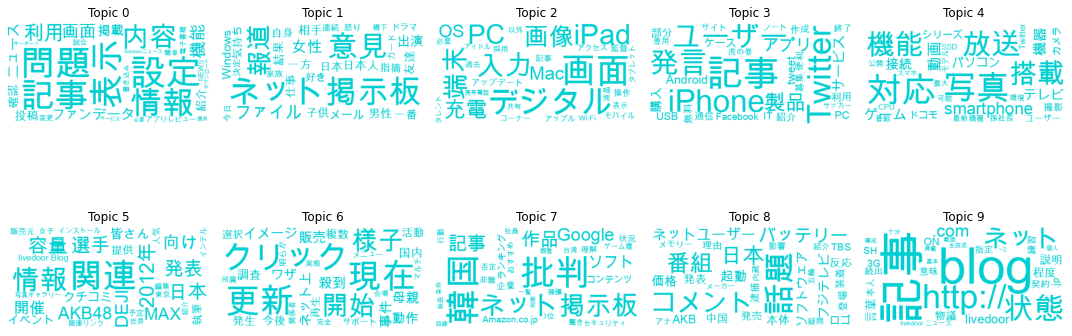